# Sampling from experiment runs

Each run of the experiment will generate checkpoints containing parameter values and sample images that make it easy to visually evaluate the performance of the model over training.
We have put together this notebook to simplify this process by focusing on how the primary image quality metric, the FID score, varies as a function of **temperature** and number of **sampling steps**.

## Setup

In [2]:
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib 
import matplotlib.cm as cm
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
import seaborn as sns

import pickle
import os
#from kcrf.estimator import simple_estimator as np_simple_est
import time 

import torch
from torch.autograd import Variable
import torch.optim as optim
from copy import deepcopy


cwd = os.getcwd()
if  os.path.basename(os.path.normpath(cwd))=='notebooks':
    os.chdir("../")

from helpers import load_dictionary

In [53]:
plt.rcParams['figure.figsize'] = [9.5, 6]
plt.rcParams['font.family'] = 'dejavu sans'
plt.rcParams['figure.figsize'] = [9.5, 6]
plt.rcParams['font.family'] = 'dejavu sans'
plt.style.use('ggplot')
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 3

sns.set(context='paper', style='whitegrid', font_scale=1.75)
sns.set_style("whitegrid", {'axes.grid' : False})

In [4]:
dirname = 'figures/'
os.makedirs(dirname, exist_ok=True)
save_figs = True
def save(n, ext='.pdf', save_figs=True, **kwargs):
    if save_figs==True:
        kwargs.setdefault('bbox_inches', 'tight')
        kwargs.setdefault('pad_inches', 0)
        kwargs.setdefault('transparent', True)
        plt.savefig(os.path.join(dirname, n + ext), **kwargs)

In [16]:
root = '/nfs/gatsbystor/michaela/projects/kale/exp/neurips/sample'
dataset = 'cifar10'
temp_dirs = []
for temp in os.scandir(os.path.join(root, dataset)):
    if temp.is_dir():
        temp_dirs.append(temp.path)
temp_dirs.sort(key = lambda x: float(os.path.basename(x).split('_')[1]))
temps = [float(os.path.basename(t).split('_')[1]) for t in temp_dirs]

filename = 'stats_seed_0.json'
out_dics = []
for idx, t in enumerate(temps):
    files = []
    for f in os.scandir(temp_dirs[idx]):
        if f.is_dir() and f.name.startswith('samples_'):
            files.append(f.name)
    if len(files) == 0:
        print('No samples files in directory', temp_dirs[idx])
    files.sort(key=lambda x: int(x.split('_')[1]))
    sample_dir = os.path.join(temp_dirs[idx], files[-1])

    full_path = os.path.join(sample_dir, filename)
    out_dics.append(load_dictionary(full_path))

print(out_dics[0])

{'fid_train': [31.74775349417314, 31.748194005101027], 'fid_test': [33.83267656461271, 33.84085499599104], 'temp': [0.01, 0.01], 'index': [0, 10], 'path_arrays': ['/nfs/gatsbystor/michaela/projects/kale/exp/neurips/sample/cifar10/temp_0.01/samples_396280_2109843/MCMC_samples_000.pkl', '/nfs/gatsbystor/michaela/projects/kale/exp/neurips/sample/cifar10/temp_0.01/samples_396280_2109843/MCMC_samples_010.pkl']}


In [5]:
out_dic.keys()

dict_keys(['fid_train', 'fid_test', 'index', 'path_arrays'])

## Plots

### FID vs temperature

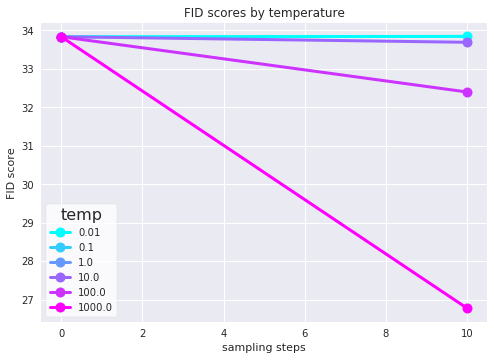

In [81]:
plt.rcParams['figure.figsize'] = [9.5, 6]
plt.rcParams['font.family'] = 'dejavu sans'
plt.style.use('seaborn')
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 3

log_temps = np.log(np.array(temps))
colors = matplotlib.cm.cool((log_temps - min(log_temps)) / (max(log_temps) - min(log_temps)))
for idx, t in enumerate(temps):
    assert t == float(out_dics[idx]['temp'][0])
    plt.plot(out_dics[idx]['index'], out_dics[idx]['fid_test'], label=t, marker='o', ms=10,color=colors[idx])

plt.legend(title='temp',loc='lower left', frameon=True,framealpha=0.8, facecolor='white')
plt.title('FID scores by temperature')
plt.ylabel('FID score')
plt.xlabel('sampling steps')
plt.show()

### FID, train vs test

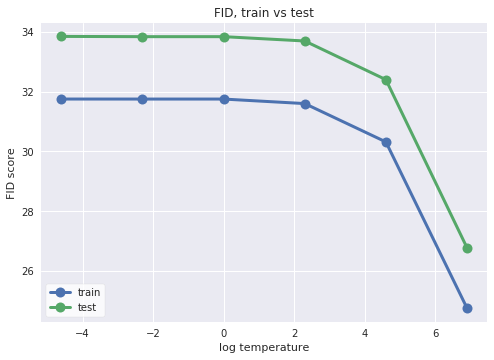

In [82]:

fids_train = []
fids_test = []
for idx, t in enumerate(temps):
    fids_train.append(out_dics[idx]['fid_train'][-1])
    fids_test.append(out_dics[idx]['fid_test'][-1])

plt.plot(log_temps, fids_train, label='train', marker='o', ms=10)
plt.plot(log_temps, fids_test, label='test', marker='o', ms=10)

plt.title('FID, train vs test')
plt.xlabel('log temperature')
plt.ylabel('FID score')
plt.legend(loc='lower left', frameon=True,framealpha=0.8, facecolor='white')

In [83]:
temps

[0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

### sample images

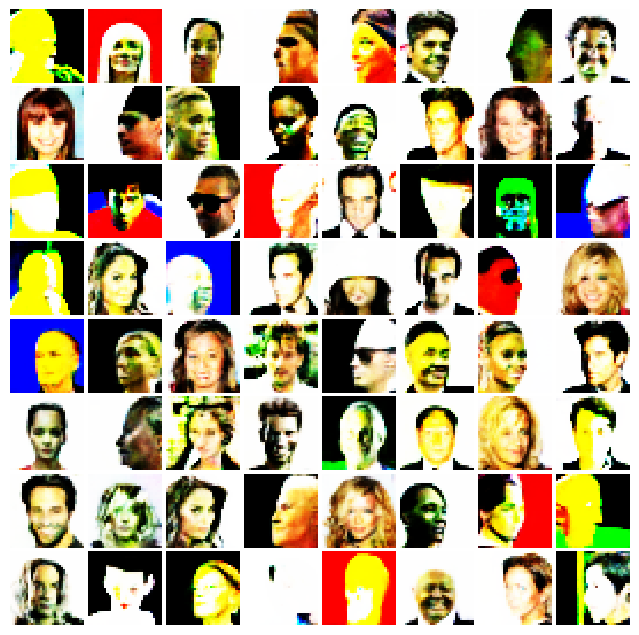

In [31]:
paths_to_arrays = out_dic['path_arrays']
images = []
latents = []
from PIL import Image
#for path in paths_to_arrays:
path = paths_to_arrays[-1]
path_revised = path.replace('MCMC_samples', 'iter').replace('.pkl', '.png')
img = Image.open(path_revised)
img
    



In [36]:
images[0].shape

(50000, 3, 32, 32)

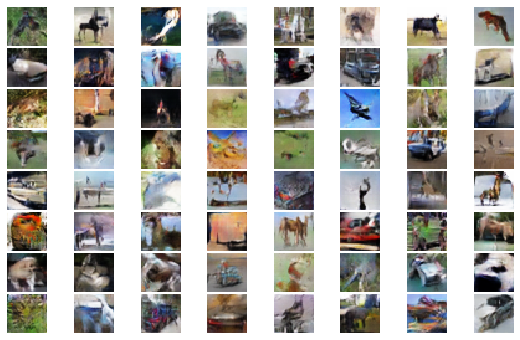

In [30]:
gs = gridspec.GridSpec(8,8)
gs.update(wspace=0.05, hspace=0.05)
samples = images[0][:64].transpose(0,2,3,1)

for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    sample_t = sample * 0.5 + 0.5
    plt.imshow(sample_t)

In [13]:
images[0].transpose(0,2,3,1).shapeb

(51000, 32, 32, 3)

In [20]:
images = np.stack(images, axis=0).transpose(0,1,3,4,2)
latents = np.stack(latents, axis=0)
